# **本章重点**

1. 策略指标构建Indicator与内置指标举例
2. 最小期的概念
3. 自定义指标
4. 回测展示中加入基准Benchmark

## **先导入所有需要用到的依赖包**

In [1]:
import backtrader as bt
import tushare as ts
import pandas as pd
import akshare as ak
import numpy as np
from backtrader.feeds import PandasData
from datetime import datetime as dt
import warnings
from datetime import datetime
import quantstats as qs

import talib as ta   # 这里需要安装talib。  pip install TA-Lib  

import backtrader.indicators as btind # 导入策略分析模块

warnings.filterwarnings("ignore")

## **加载我们用到的数据**

**注意：数据日期升序排列，并且是DataTime格式，不是string格式**

In [2]:
start_date = '20150101'
end_date   = '20230101'
symbol     = '000001' 

stock_zh_a_hist_df = ak.stock_zh_a_hist(symbol=symbol, period="daily", start_date=start_date, end_date=end_date, adjust="hfq")
stock_zh_a_hist_df.rename(columns={'日期':'date','开盘':'open','收盘':'close','最高':'high','最低':'low','成交量':'volume','换手率':'turnover'},inplace=True)
stock_zh_a_hist_df = stock_zh_a_hist_df[['date', 'open', 'high', 'low', 'close', 'volume']]
stock_zh_a_hist_df.date=pd.to_datetime(stock_zh_a_hist_df.date)
stock_zh_a_hist_df.head()

,date,open,high,low,close,volume
0,2015-01-05,1797.18,1829.92,1753.17,1800.57,2860436
1,2015-01-06,1781.38,1842.33,1747.52,1773.48,2166421
2,2015-01-07,1748.65,1779.13,1719.31,1739.62,1700121
3,2015-01-08,1741.88,1749.78,1674.16,1680.93,1407714
4,2015-01-09,1674.16,1783.64,1652.72,1694.48,2508500


## **提前构造好需要载入的数据**

In [3]:
stock_data = PandasData(
                dataname=stock_zh_a_hist_df,
                datetime=0,  # 日期列
                open=1,  # 开盘价所在列
                high=2,  # 最高价所在列
                low=3,  # 最低价所在列
                close=4,  # 收盘价所在列
                volume=5,
                fromdate=dt.strptime(start_date, '%Y%m%d'),  # 起始日  dt.strptime(start, '%Y%m%d')
                todate=dt.strptime(end_date, '%Y%m%d'),  # 结束日
            )

## **构建一个函数，能够快速回测**

In [4]:
def backtest(strategy, mode='basic'):
    cerebro = bt.Cerebro()
    
    cerebro.adddata(stock_data, name='stock')
    
    start_cash=1000000
    
    cerebro.addstrategy(strategy)
    # 设置现金
    cerebro.broker.setcash(start_cash)
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
    
    print('初始市值：%.2f' % cerebro.broker.getvalue())
    results = cerebro.run()
    strat = results[0]
    
    portfolio_stats = strat.analyzers.getbyname('PyFolio')
    returns, _,_,_ = portfolio_stats.get_pf_items()
    
    returns.index=returns.index.tz_convert(None)
    print('最终市值：%.2f' % cerebro.broker.getvalue())
    
    """
    qs.reports.metrics(mode='basic|full', ...) - shows basic/full metrics
    qs.reports.plots(mode='basic|full', ...) - shows basic/full plots
    qs.reports.basic(...) - shows basic metrics and plots
    qs.reports.full(...) - shows full metrics and plots
    qs.reports.html(...) - generates a complete report as html
    """
    if mode == 'basic':
        qs.reports.basic(returns)
    elif mode == 'full':
        qs.reports.full(returns)
    elif mode == 'simple':
        qs.plots.snapshot(returns, title='Performance')

## **1.策略指标构建Indicator**

**策略的指标计算大致有两种方式**

**1.1** 第一种我们在第三节课中有用到过，直接在Data模块中把指标计算好，然后倒入到回测引擎中，通过数据self.data的方式获取提前计算好的指标，这种方法可以传入更多自定义的指标类型，比如基本面的、机器学习等的交易信号

![盘口](images/第三节课的指标.png)

**1.2** 第二种方式是通过backtrader内部提供的Indicator对象来构造指标，这种指标更加偏向技术类的指标，最常用的是Talib模块

> [talib函数大全](https://www.windquant.com/qntcloud/article?5750f071-4e6e-4922-b007-71db3733835d)

### **通过Indicator构造最简单的指标举例**

##### 通过Indicator构造指标的具体实现方式也有很多种，我们一个一个来学习

#### **第一种写法：所有指标都记到类属性中**

In [5]:
class Strategy01(bt.Strategy):
    params = {
        'period01':10, 'period02': 20
    }
    
    def __init__(self):
        # 先在 __init__ 中提前算好指标，单只股票的情况下，直接用self.data就是默认指向了第一支股票的close价格（也是唯一一支）
        self.sma1 = btind.SimpleMovingAverage(self.data, period=self.params.period01)
        self.ema1 = btind.ExponentialMovingAverage(self.data, period=self.params.period02)  # line
        
        self.count = 0
        
    def next(self):
        self.count += 1
        
        if self.count < 10:
            print('self.sma1:', self.sma1[0])
            print('self.ema1:', self.ema1[0])
        
        size = int(self.broker.getvalue() / self.datas[0].close // 100 * 100)  # 股数
        
        # self.data.close与self.sma1等都是单个数值，默认是self.data.close[0]
        cond01 = self.data.close > self.sma1
        cond02 = self.data.close > self.ema1
        cond03 = self.sma1 > self.ema1
        
        if not self.position.size:  # 还没有仓位的情况下，观察入场信号
            if cond01 and cond02 and cond03:
                self.buy(size=size)
        else:  # 有仓位的情况下，观察离场信号
            if not cond01 and not cond02 and not cond03:
                self.close()
        

初始市值：1000000.00
self.sma1: 1583.865
self.ema1: 1647.6354999999999
self.sma1: 1581.608
self.ema1: 1636.510214285714
self.sma1: 1582.9630000000002
self.ema1: 1629.8844795918365
self.sma1: 1574.95
self.ema1: 1621.3097672497568
self.sma1: 1569.194
self.ema1: 1614.4116941783514
self.sma1: 1559.149
self.ema1: 1605.1610566375562
self.sma1: 1549.894
self.ema1: 1596.8980988625508
self.sma1: 1547.411
self.ema1: 1592.1097084946887
self.sma1: 1543.687
self.ema1: 1587.3478314951944
最终市值：879367.00


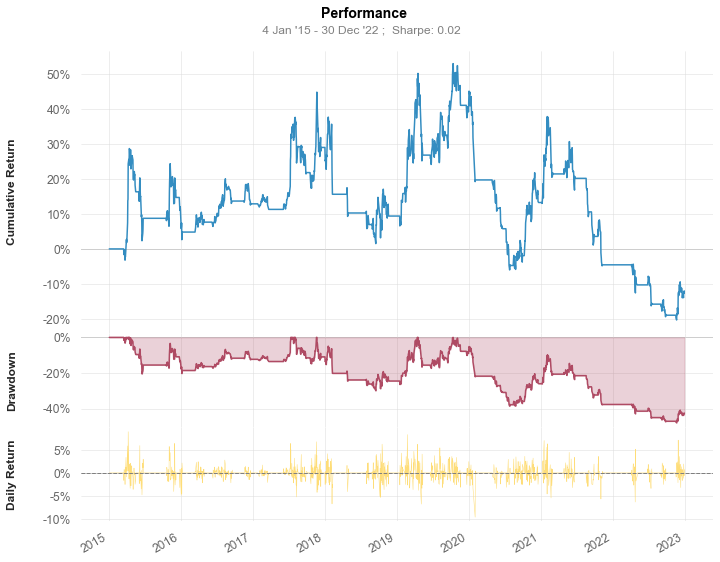

In [6]:
backtest(Strategy01, mode='simple')

#### **第二种写法：类属性中只记录信号**

In [7]:
class Strategy02(bt.Strategy):
    params = {
        'period01':5, 'period02': 5
    }
    
    def __init__(self):
        # 先在 __init__ 中提前算好指标，单只股票的情况下，直接用self.data就是默认指向了第一支股票的close价格（也是唯一一支）
        sma1 = btind.SimpleMovingAverage(self.data, period=self.p.period01)
        ema1 = btind.ExponentialMovingAverage(self.data, period=self.p.period02)
        
        # 下面的都是序列
        # cond01 = self.data.close > sma1
        # cond02 = self.data.close > ema1
        cond03 = sma1 > ema1
        
        # self.buy_signal = cond01 and cond02 and cond03
        # self.sell_signal = not cond01 and not cond02 and not cond03
        
        self.buy_signal = cond03
        self.sell_signal = bt.And(sma1 < ema1)
        
        self.count = 0
        
    def next(self):
        self.count += 1
        
        if self.count < 10:
            print('self.buy_signal:', self.buy_signal[0])
            print('self.sell_signal:', self.sell_signal[0])
        
        size = int(self.broker.getvalue() / self.datas[0].close // 100 * 100)  # 股数
        
        
        if not self.position.size:  # 还没有仓位的情况下，观察入场信号
            if self.buy_signal:
                self.buy(size=size)
        else:  # 有仓位的情况下，观察立场信号
            if self.sell_signal:
                self.close()
        

初始市值：1000000.00
self.buy_signal: 0.0
self.sell_signal: 0.0
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 1.0
self.sell_signal: 0.0
self.buy_signal: 1.0
self.sell_signal: 0.0
self.buy_signal: 1.0
self.sell_signal: 0.0
最终市值：580945.00


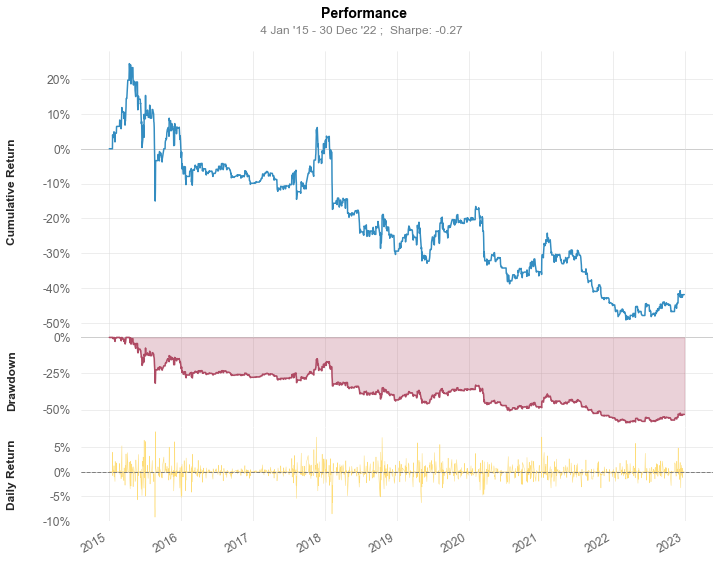

In [8]:
backtest(Strategy02, mode='simple')

In [9]:
class Strategy03(bt.Strategy):
    params = {
        'period01':5, 'period02': 5
    }
    
    def __init__(self):
        # 先在 __init__ 中提前算好指标，单只股票的情况下，直接用self.data就是默认指向了第一支股票的close价格（也是唯一一支）
        sma1 = btind.SMA(self.data, period=self.p.period01)
        ema1 = btind.ExponentialMovingAverage( period=self.p.period02)
        
        # 下面的都是序列
        cond01 = bt.Cmp(self.data.close, sma1)
        
        cond02 = self.data.close > ema1
        
        # cond03 = sma1 > ema1
        
        
        self.buy_signal = bt.And(self.data.close>sma1, self.data.close > ema1)
        self.sell_signal = bt.And(self.data.close<sma1, self.data.close < ema1)
        
        self.count = 0
        
    def next(self):
        self.count += 1
        
        if self.count < 10:
            print('self.buy_signal:', self.buy_signal[0])
            print('self.sell_signal:', self.sell_signal[0])
        
        size = int(self.broker.getvalue() / self.datas[0].close // 100 * 100)  # 股数
        
        
        if not self.position.size:  # 还没有仓位的情况下，观察入场信号
            if self.buy_signal:
                self.buy(size=size)
        else:  # 有仓位的情况下，观察立场信号
            if self.sell_signal:
                self.close()
        

初始市值：1000000.00
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 1.0
self.sell_signal: 0.0
self.buy_signal: 1.0
self.sell_signal: 0.0
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 0.0
self.sell_signal: 1.0
最终市值：1409786.00


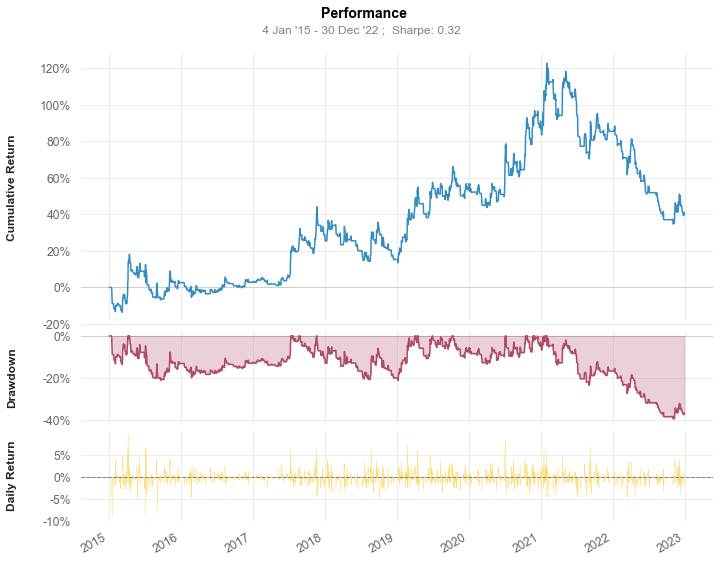

In [10]:
backtest(Strategy03, mode='simple')

### **总结上面的运算函数：**

基于整条 line 进行运算，返回的结果也是 lines 

**bt.And**


**bt.Or**

**bt.If**

**bt.All**

**bt.Any**

**bt.Max**

**bt.Min**

**bt.Sum**

**bt.Cmp**

```
假设有两个均线 sma5和sma10
self.sma5 = btind.SimpleMovingAverage(period=5) # 5日均线
self.sma10 = btind.SimpleMovingAverage(period=10) # 10日均线

# bt.And 中所有条件都满足时返回 1；有一个条件不满足就返回 0
self.And = bt.And(self.data>self.sma5, self.data>self.sma10, self.sma5>self.sma10)

# bt.Or 中有一个条件满足时就返回 1；所有条件都不满足时返回 0
self.Or = bt.Or(self.data>self.sma5, self.data>self.sma10, self.sma5>self.sma10)

# bt.If(a, b, c) 如果满足条件 a，就返回 b，否则返回 c
self.If = bt.If(self.data>self.sma5,1000, 5000)

# bt.All,同 bt.And
self.All = bt.All(self.data>self.sma5, self.data>self.sma10, self.sma5>self.sma10)

# bt.Any，同 bt.Or
self.Any = bt.Any(self.data>self.sma5, self.data>self.sma10, self.sma5>self.sma10)

# bt.Max，返回同一时刻所有指标中的最大值
self.Max = bt.Max(self.data, self.sma10, self.sma5)

# bt.Min，返回同一时刻所有指标中的最小值
self.Min = bt.Min(self.data, self.sma10, self.sma5)

# bt.Sum，对同一时刻所有指标进行求和
self.Sum = bt.Sum(self.data, self.sma10, self.sma5)

# bt.Cmp(a,b), 如果 a>b ，返回 1；否则返回 -1
self.Cmp = bt.Cmp(self.data, self.sma5)
```

### **TaLib的指标样例**

In [11]:
class TALibStrategy(bt.Strategy):
    def __init__(self):
        # 计算 5 日均线
        bt.talib.SMA(self.data.close, timeperiod=5)
        bt.indicators.SMA(self.data, period=5)
        # 计算布林带
        bt.talib.BBANDS(self.data, timeperiod=25)
        bt.indicators.BollingerBands(self.data, period=25)

## **2.最小期**

最小期是指计算技术指标所需要的最小的行情数据bar的数量，如果不同的指标需要的最小bar数量不同，则取大者为策略最小期

## **3.自定义新指标**

#### **第一种方式**

In [12]:
class Ind01(bt.Indicator):
    lines = ('gold',)
    params = dict(period_slow=10, period_fast=5)
    def __init__(self):
        sma_fast = bt.ind.MovingAverageSimple(self.data, period=self.p.period_fast)
        sma_slow = bt.ind.MovingAverageSimple(self.data, period=self.p.period_slow)
        self.lines.gold = bt.Cmp(sma_fast, sma_slow)

#### **第二种方式**

In [13]:
class Ind02(bt.Indicator):
    lines = ('gold',)
    params = dict(period_fast=5, period_slow=10)
    def __init__(self):
        self.addminperiod(self.p.period_slow)
    
    def next(self):
        fast_data_sum: int = math.fsum(self.data.get(size=self.p.period_fast))
        slow_data_sum = math.fsum(self.data.get(size=self.p.period_slow))
        sma_fast = fast_data_sum / self.p.period_fast
        sma_slow = fast_data_sum / self.p.period_slow
        buy_signal: bool = sma_fast > sma_slow

### **两种方式的比较**

上面两种方式都可以定义指标，但是第一种方式在init方法中就把所有数据算完了，性能会更好，第二种方式需要每一次在next方法中运行最新的指标值，性能会差很多，因此在能够使用第一种方式的情况下就尽量用第一种，除非无法计算，只能用第二种

### **举一个案例**

[ARBR 情绪指标](https://www.moomoo.com/sg/hans/support/topic3_157)

         date   open  close   high    low  volume
0  2018-06-11  14.66  18.01  18.01  14.66     788
1  2018-06-12  20.02  20.02  20.02  20.02     266
2  2018-06-13  22.24  22.24  22.24  22.24     450
3  2018-06-14  24.67  24.67  24.67  24.67     743
4  2018-06-15  27.35  27.35  27.35  27.35    2565
起始市值: 100000.00
2020-04-29, 买单执行,, 73.61, 1300, 共95693.00
2020-08-14, 卖单执行, , 107.94, -1300, 共-140322.00
2020-08-14, 日期：20200814, 交易完毕, , 毛收益 44629.00, 扣佣后收益  44392.99, 佣金 236.01, 市值 144392.99
2020-10-13, 买单执行,, 128.59, 1100, 共141449.00
2020-11-23, 卖单执行, , 138.15, -1100, 共-151965.00
2020-11-23, 日期：20201123, 交易完毕, , 毛收益 10516.00, 扣佣后收益  10222.59, 佣金 293.41, 市值 154615.57
2020-12-23, 买单执行,, 172.37, 800, 共137896.00
2021-02-02, 卖单执行, , 193.67, -800, 共-154936.00
2021-02-02, 日期：20210202, 交易完毕, , 毛收益 17040.00, 扣佣后收益  16747.17, 佣金 292.83, 市值 171362.74
2021-02-05, 买单执行,, 217.55, 700, 共152285.00
2021-02-09, 卖单执行, , 226.55, -700, 共-158585.00
2021-02-09, 日期：20210209, 交易完毕, , 毛收益 6300.00, 扣佣后收益  5989.13, 

                           Strategy
-------------------------  ----------
Start Period               2020-01-02
End Period                 2023-09-08
Risk-Free Rate             0.0%
Time in Market             60.0%

Cumulative Return          24.13%
CAGR﹪                     4.13%

Sharpe                     0.35
Prob. Sharpe Ratio         74.55%
Smart Sharpe               0.34
Sortino                    0.54
Smart Sortino              0.53
Sortino/√2                 0.38
Smart Sortino/√2           0.37
Omega                      1.08

Max Drawdown               -46.83%
Longest DD Days            645
Volatility (ann.)          33.03%
Calmar                     0.09
Skew                       0.79
Kurtosis                   5.02

Expected Daily %           0.02%
Expected Monthly %         0.48%
Expected Yearly %          5.55%
Kelly Criterion            3.51%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.38%
Expected Shortfall (cVaR)  -3.38%

Max Consecutive Wins       6

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-12-03,2023-03-17,2023-09-08,645,-46.826547,-45.256256
2,2021-01-08,2021-02-05,2021-10-28,294,-18.062196,-16.141863
3,2020-07-14,2020-10-23,2020-11-04,114,-15.520234,-14.485560
4,2020-11-06,2020-11-18,2020-12-29,54,-10.379277,-9.791897
5,2020-05-07,2020-05-14,2020-05-19,13,-6.884014,-5.521807


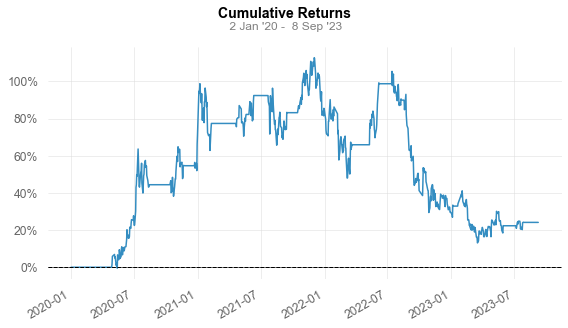

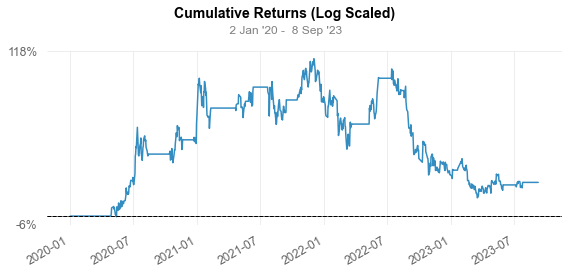

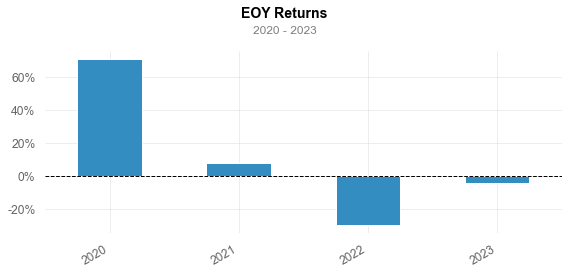

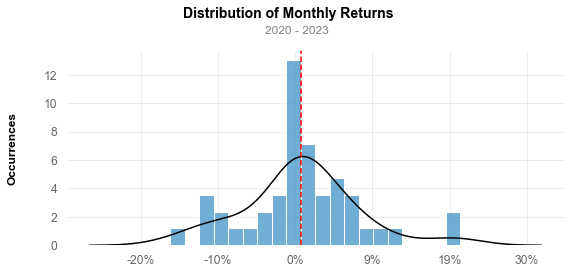

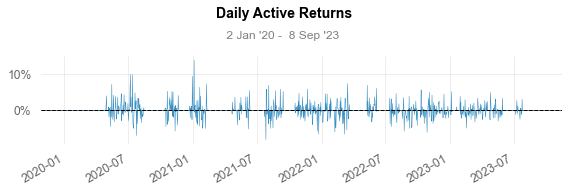

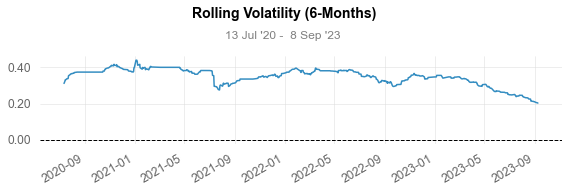

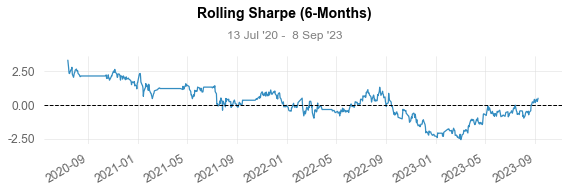

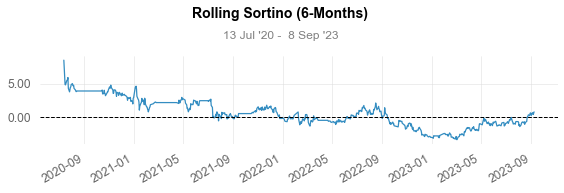

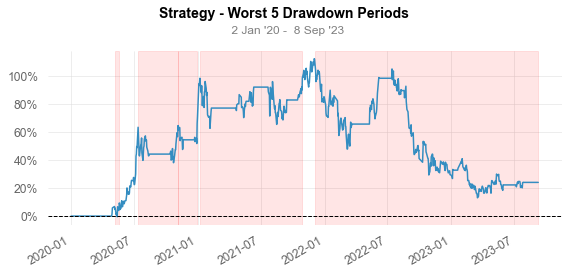

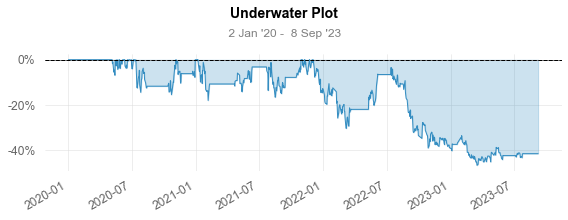

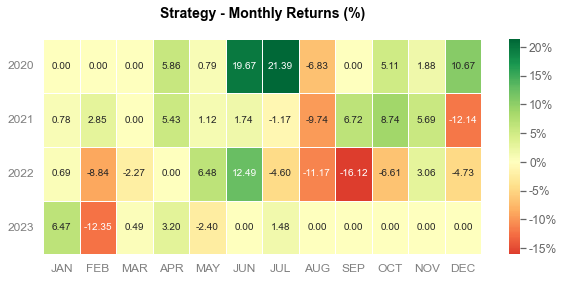

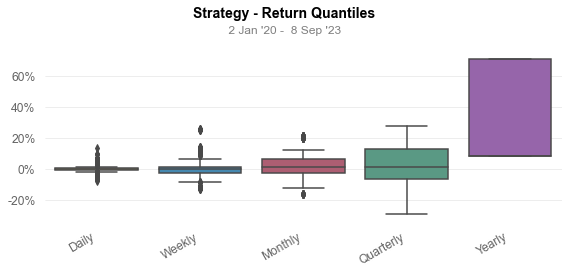

In [14]:
class ARBR(bt.Indicator):
    lines = ('ar', 'br',)
    params = (('period', 26),)

    def __init__(self):
        self.addminperiod(self.params.period + 1)  # 设置最小期，由于arbr中需要用到前一日的

    def next(self):
        high = np.array(self.data.high.get(size=self.params.period)) # self.data.high.get会取最近n个数据
        open_ = np.array(self.data.open.get(size=self.params.period))
        low = np.array(self.data.low.get(size=self.params.period))
        close = np.array(self.data.close.get(size=self.params.period + 1))
        volume = np.array(self.data.volume.get(size=self.params.period))
        
        ar: float = np.sum((high - open_)) / np.sum((open_ - low)) * 100
        br: float = np.sum((high - close[:self.p.period])) / np.sum((close[:self.p.period] - low)) * 100

        self.lines.ar[0] = ar
        self.lines.br[0] = br

class ARBRStrategy(bt.Strategy):
    params = (('ar_threshold', 110), ('br_threshold', 110),)

    def __init__(self):
        self.arbr = ARBR(self.data)
        self.buy_signal = bt.indicators.CrossOver(self.arbr.ar, self.params.ar_threshold)
        self.sell_signal = bt.indicators.CrossOver(self.arbr.br, self.params.br_threshold)
    
    def log(self, txt, dtt=None):
        # 以第一个数据data0，即指数作为时间基准
        dtt = dtt or self.data0.datetime.date(0)
        print('%s, %s' % (dtt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # 订单状态 submitted/accepted，无动作
            return

        # 订单完成
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行,%s, %.2f, %i, 共%.2f' % (order.data._name,
                                                order.executed.price, order.executed.size, order.executed.price * order.executed.size))

            elif order.issell():
                self.log('卖单执行, %s, %.2f, %i, 共%.2f' % (order.data._name,
                                                order.executed.price, order.executed.size,  order.executed.price * order.executed.size))

        else:
            self.log('订单作废 %s, %s, isbuy=%i' %
                     (order.data._name, order.getstatusname(), order.isbuy()))

    def notify_trade(self, trade):
        if trade.isclosed:
            date = trade.data.datetime.date(0).strftime('%Y%m%d')
            name = trade.data._name
            pnl = trade.pnl
            
            self.log('日期：%s, 交易完毕, %s, 毛收益 %0.2f, 扣佣后收益 % 0.2f, 佣金 %.2f, 市值 %.2f' %
                  (trade.data.datetime.date(0).strftime('%Y%m%d'), trade.data._name, trade.pnl, trade.pnlcomm, trade.commission, self.broker.getvalue()))

    
    def next(self):
        if not self.position.size:  # 还没有仓位
            
            if self.buy_signal > 0:
                size = int((self.broker.getvalue() / self.data.open[1]) // 100 * 100)
                self.buy(size=size)
        
        elif self.sell_signal > 0:
            self.close()
        

cerebro = bt.Cerebro()

stock_qfq_df=ak.stock_zh_a_hist(symbol="300750", adjust="qfq").iloc[:, :6]
#处理字段命名，来符合Backtrader模块的要求
stock_qfq_df.columns=['date','open','close','high','low','volume']
print(stock_qfq_df.head())
#把date作为日期索引，以符合Backtrader的要求
stock_qfq_df.index=pd.to_datetime(stock_qfq_df['date'])


start_date=datetime(2020, 1, 1)#回测开始时间
end_date=datetime.now()#回测结束时间
data=bt.feeds.PandasData(dataname=stock_qfq_df,fromdate=start_date,todate=end_date)#加载数据
cerebro.adddata(data)#将数据传入回测系统

cerebro.broker.setcommission(commission=0.001)#设置交易手续费为0.1%
# 设置现金
cerebro.broker.setcash(100000)
cerebro.addstrategy(ARBRStrategy)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

print('起始市值: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, _,_,_ = portfolio_stats.get_pf_items()

returns.index=returns.index.tz_convert(None)
print(f'================================= 回测结束 {dt.now().strftime("%Y%m%d %H:%M:%S")} =========================================')
qs.reports.full(returns)

初始市值：1000000.00
2015-03-13, 买单执行,stock, 1674.16, 500, 共837080.00
2015-10-21, 卖单执行, stock, 1541.20, -500, 共-770600.00
2015-10-21, 日期：20151021, 交易完毕, stock, 毛收益 -66480.00, 扣佣后收益 -66480.00, 佣金 0.00, 市值 933520.00
2015-12-18, 买单执行,stock, 1641.43, 500, 共820715.00
2016-03-18, 卖单执行, stock, 1423.37, -500, 共-711685.00
2016-03-18, 日期：20160318, 交易完毕, stock, 毛收益 -109030.00, 扣佣后收益 -109030.00, 佣金 0.00, 市值 824490.00
2016-03-31, 买单执行,stock, 1462.65, 500, 共731325.00
2016-04-14, 卖单执行, stock, 1485.67, -500, 共-742835.00
2016-04-14, 日期：20160414, 交易完毕, stock, 毛收益 11510.00, 扣佣后收益  11510.00, 佣金 0.00, 市值 836000.00
2016-06-28, 买单执行,stock, 1427.30, 500, 共713650.00
2016-07-14, 卖单执行, stock, 1490.68, -500, 共-745340.00
2016-07-14, 日期：20160714, 交易完毕, stock, 毛收益 31690.00, 扣佣后收益  31690.00, 佣金 0.00, 市值 867690.00
2016-09-12, 买单执行,stock, 1542.69, 500, 共771345.00
2016-11-24, 卖单执行, stock, 1567.07, -500, 共-783535.00
2016-11-24, 日期：20161124, 交易完毕, stock, 毛收益 12190.00, 扣佣后收益  12190.00, 佣金 0.00, 市值 879880.00
2017-02-03, 买单执行,sto

                    Strategy
------------------  ----------
Start Period        2015-01-05
End Period          2022-12-30
Risk-Free Rate      0.0%
Time in Market      50.0%

Cumulative Return   -34.37%
CAGR﹪              -3.57%

Sharpe              -0.14
Prob. Sharpe Ratio  34.47%
Sortino             -0.2
Sortino/√2          -0.14
Omega               0.96

Max Drawdown        -55.91%
Longest DD Days     2762

Gain/Pain Ratio     -0.04
Gain/Pain (1M)      -0.14

Payoff Ratio        1.03
Profit Factor       0.96
Common Sense Ratio  0.99
CPC Index           0.48
Tail Ratio          1.03
Outlier Win Ratio   10.0
Outlier Loss Ratio  3.37

MTD                 0.65%
3M                  6.88%
6M                  -3.45%
YTD                 -4.95%
1Y                  -6.14%
3Y (ann.)           -10.91%
5Y (ann.)           -5.38%
10Y (ann.)          -3.57%
All-time (ann.)     -3.57%

Avg. Drawdown       -11.78%
Avg. Drawdown Days  471
Recovery Factor     0.43
Ulcer Index         0.35
Serenity Inde

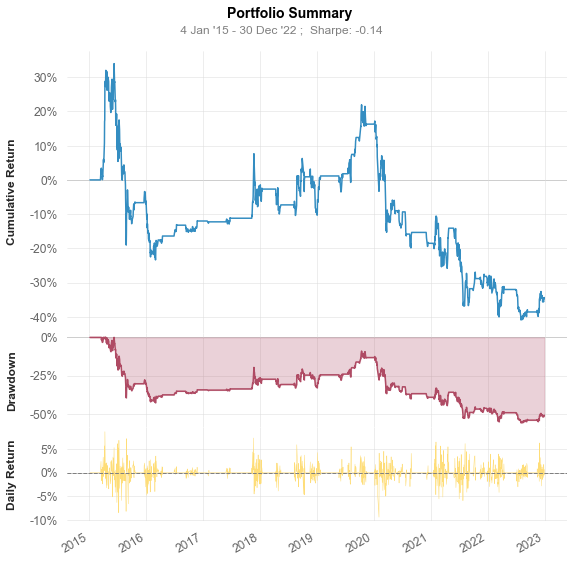

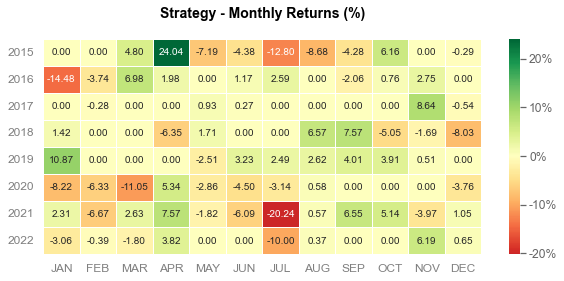

In [15]:
backtest(ARBRStrategy)

## **4.回测展示中加入基准Benchmark**

### **在回测中加入benchmark非常简单**

#### **查看可用的指数**

In [16]:
index_stock_info_df = ak.index_stock_info()
index_stock_info_df.head()

,index_code,display_name,publish_date
0,000001,上证指数,1991-07-15
1,000002,A股指数,1992-02-21
2,000003,B股指数,1992-02-21
3,000004,工业指数,1993-05-03
4,000005,商业指数,1993-05-03


In [17]:
index_stock_info_df[index_stock_info_df.display_name.str.contains('沪深300')]

,index_code,display_name,publish_date
143,000300,沪深300,2005-04-08
198,000849,沪深300非银行金融指数,2012-12-21
199,000850,沪深300有色金属指数,2012-12-21
379,399300,沪深300,2005-04-08
628,399908,沪深300能源指数,2007-07-02
629,399909,沪深300原材料指数,2007-07-02
630,399910,沪深300工业指数,2007-07-02
631,399911,沪深300可选消费指数,2007-07-02
632,399912,沪深300主要消费指数,2007-07-02
633,399913,沪深300医药卫生指数,2007-07-02


In [18]:
index_stock_info_df[index_stock_info_df.display_name.str.contains('中证500')]

,index_code,display_name,publish_date
213,000905,中证500,2007-01-15
625,399905,中证500,2007-01-15
699,399982,中证500等权重指数,2011-06-13


In [19]:
stock_zh_index_daily_df = ak.stock_zh_index_daily(symbol="sz399300")
# stock_zh_index_daily_df = ak.stock_zh_index_daily(symbol="sh000003")

stock_zh_index_daily_df.date = pd.to_datetime(stock_zh_index_daily_df.date)
stock_zh_index_daily_df


,date,open,high,low,close,volume
0,2002-01-04,1316.455,1316.455,1316.455,1316.455,0
1,2002-01-07,1302.084,1302.084,1302.084,1302.084,0
2,2002-01-08,1292.714,1292.714,1292.714,1292.714,0
3,2002-01-09,1272.645,1272.645,1272.645,1272.645,0
4,2002-01-10,1281.261,1281.261,1281.261,1281.261,0
...,...,...,...,...,...,...
5258,2023-09-04,3812.987,3854.260,3804.589,3848.952,14238520100
5259,2023-09-05,3839.578,3839.578,3814.334,3820.317,10405233300
5260,2023-09-06,3808.100,3817.524,3790.895,3812.028,9344239300
5261,2023-09-07,3802.227,3802.227,3756.853,3758.475,9510390300


#### 上面的函数封装的不够完善，我们重新封装

In [20]:
def backtest(strategy, stock_code, index_code,
             start_date,end_date, 
             start_cash=1000000, mode='basic'):
    cerebro = bt.Cerebro()
    stock_data = ak.stock_zh_a_hist(symbol=stock_code, period="daily", start_date=start_date, end_date=end_date, adjust="hfq")
    stock_data.rename(columns={'日期':'date','开盘':'open','收盘':'close','最高':'high','最低':'low','成交量':'volume','换手率':'turnover'},inplace=True)
    stock_data = stock_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    stock_data.date=pd.to_datetime(stock_data.date)

    stock_data = PandasData(
                dataname=stock_data,
                datetime=0, 
                open=1, 
                high=2,
                low=3,
                close=4,
                volume=5,
                fromdate=dt.strptime(start_date, '%Y%m%d'),  # 起始日  dt.strptime(start, '%Y%m%d')
                todate=dt.strptime(end_date, '%Y%m%d'),  # 结束日
            )
    
    index_code = f'sz{index_code}' if str(index_code).startswith('3') else f'sh{index_code}'
    stock_zh_index_daily_df = ak.stock_zh_index_daily(symbol=index_code)

    stock_zh_index_daily_df.date = pd.to_datetime(stock_zh_index_daily_df.date)
    
    cerebro.adddata(stock_data, name='stock')

    

    cerebro.addstrategy(strategy)
    # 设置现金
    cerebro.broker.setcash(start_cash)
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

    print('初始市值: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run()
    strat = results[0]

    portfolio_stats = strat.analyzers.getbyname('PyFolio')
    returns, _,_,_ = portfolio_stats.get_pf_items()

    returns.index=returns.index.tz_convert(None)
    print('最终市值: %.2f' % cerebro.broker.getvalue())
    
    """
    qs.reports.metrics(mode='basic|full", ...) - shows basic/full metrics
    qs.reports.plots(mode='basic|full", ...) - shows basic/full plots
    qs.reports.basic(...) - shows basic metrics and plots
    qs.reports.full(...) - shows full metrics and plots
    qs.reports.html(...) - generates a complete report as html
    """
    
    bm = stock_zh_index_daily_df[['date','close']]
    bm.set_index('date', inplace=True)
    bm.rename(columns={'close':'price'}, inplace=True)
    bm = bm.loc[start_date:end_date]
    if mode == 'basic':
        qs.reports.basic(returns, benchmark=bm)
    elif mode == 'full':
        qs.reports.full(returns, benchmark=bm)
    elif mode == 'simple':
        qs.plots.snapshot(returns, title='Performance')

初始市值: 1000000.00
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 1.0
self.sell_signal: 0.0
self.buy_signal: 1.0
self.sell_signal: 0.0
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 0.0
self.sell_signal: 1.0
self.buy_signal: 0.0
self.sell_signal: 1.0
最终市值: 1409786.00


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2015-01-16   2015-01-16
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       57.0%

Cumulative Return          7.62%        40.98%
CAGR﹪                     0.64%        3.02%

Sharpe                     0.17         0.32
Prob. Sharpe Ratio         68.09%       81.37%
Smart Sharpe               0.17         0.32
Sortino                    0.22         0.5
Smart Sortino              0.22         0.49
Sortino/√2                 0.16         0.35
Smart Sortino/√2           0.16         0.35
Omega                      1.08         1.08

Max Drawdown               -65.2%       -39.54%
Longest DD Days            2756         818
Volatility (ann.)          26.61%       20.6%
R^2                        0.04         0.04
Information Ratio          0.0          0.0
Calmar                  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-02-02,2022-11-04,2022-12-30,697,-39.536870,-39.186722
2,2017-11-23,2019-01-08,2019-04-03,497,-21.217375,-20.676251
3,2015-04-17,2015-09-23,2017-07-12,818,-21.117850,-20.499249
4,2019-10-15,2020-04-03,2020-07-03,263,-13.515472,-12.752948
5,2015-01-19,2015-03-10,2015-04-07,79,-13.453737,-13.114664


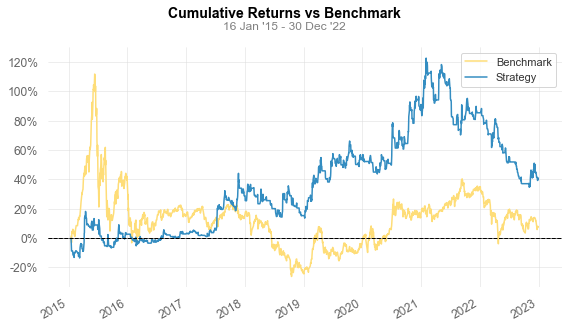

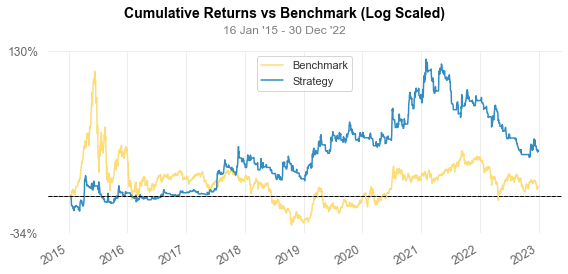

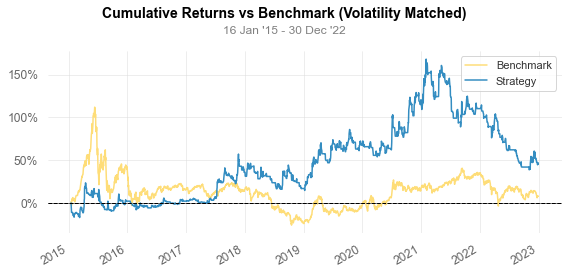

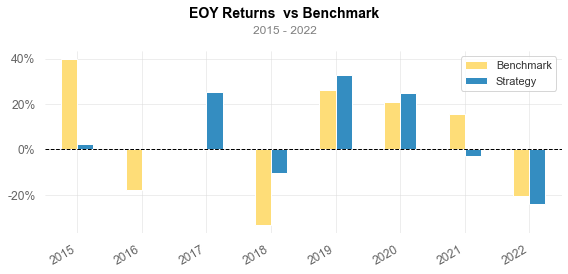

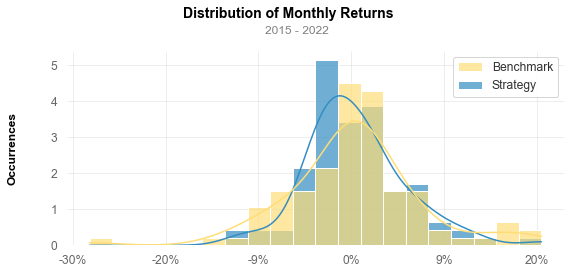

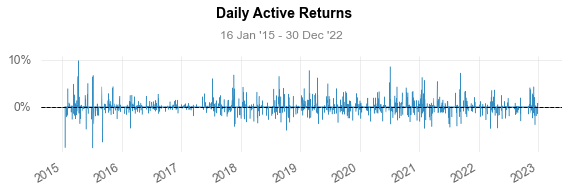

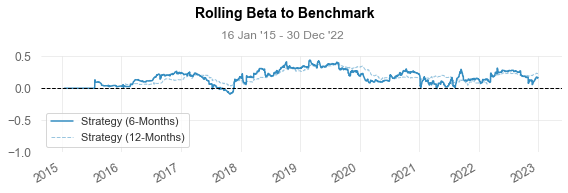

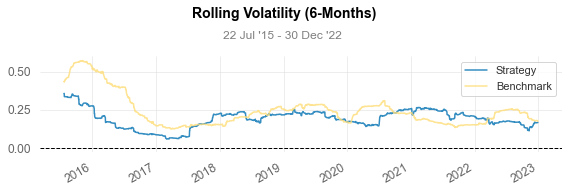

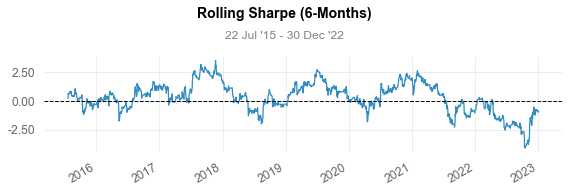

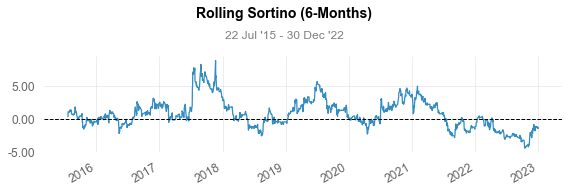

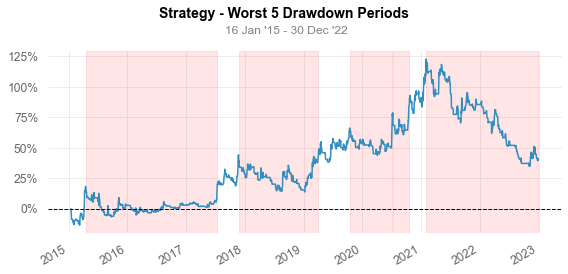

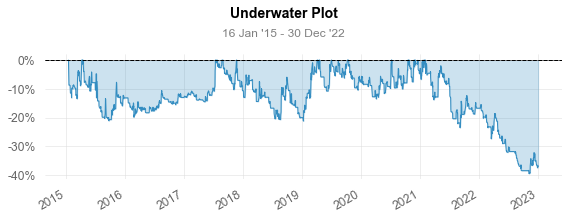

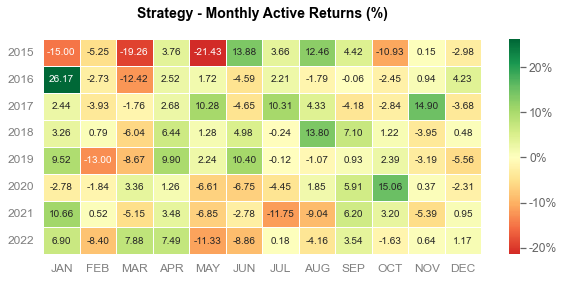

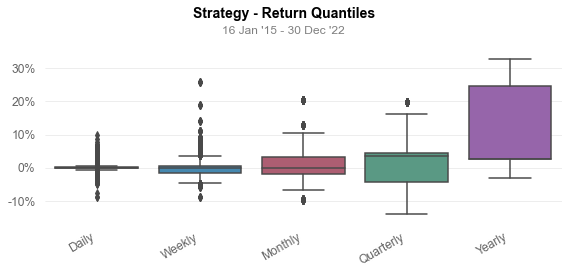

In [21]:
strategy = Strategy03
start_date = '20150101'
end_date   = '20230101'
stock_code = '000001'
index_code = '000905'

backtest(strategy, stock_code, index_code,
             start_date,end_date, 
             start_cash=1000000, mode='full')